In [1]:
from keystone.model import Net
from keystone.keystone import calculate_keystone_array
from keystone.data_loading import process_data

from main import train
from types import SimpleNamespace

import seaborn as sns
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# GLV model data

In [22]:
# training_params = SimpleNamespace(
#         file_path = './data/DKI_data/Ptrain.csv',
#         batch_size = 32,
#         val_size = 0.1,
#         lr = 0.01,
#         epochs = 5000,
#         verbosity = 500,
#         layers = [512],
#         output_name = 'DKI_data_NLLoss',
#     )

training_params = SimpleNamespace(
        file_path = './data/DKI_data/Ptrain.csv',
        batch_size = 32,
        val_size = 0.1,
        lr = 0.005,
        epochs = 6000,
        verbosity = 500,
        layers = [256],
        output_name = 'DKI_data_NLLoss',
    )

In [23]:
loss, network, train_loader, val_loader = train(training_params)

Epoch: 0 	Training Loss: 8.67e-01 	Validation Loss: 8.02e-01
Epoch: 500 	Training Loss: 7.15e-03 	Validation Loss: 7.45e-03
Epoch: 1000 	Training Loss: 7.06e-03 	Validation Loss: 7.31e-03
Epoch: 1500 	Training Loss: 5.31e-03 	Validation Loss: 6.24e-03
Epoch: 2000 	Training Loss: 2.21e-03 	Validation Loss: 3.34e-03
Epoch: 2500 	Training Loss: 1.00e-03 	Validation Loss: 1.95e-03
Epoch: 3000 	Training Loss: 5.65e-04 	Validation Loss: 1.32e-03
Epoch: 3500 	Training Loss: 4.01e-04 	Validation Loss: 1.11e-03
Epoch: 4000 	Training Loss: 3.32e-04 	Validation Loss: 1.01e-03
Epoch: 4500 	Training Loss: 3.01e-04 	Validation Loss: 9.98e-04
Epoch: 5000 	Training Loss: 2.78e-04 	Validation Loss: 9.93e-04
Epoch: 5500 	Training Loss: 2.61e-04 	Validation Loss: 9.76e-04


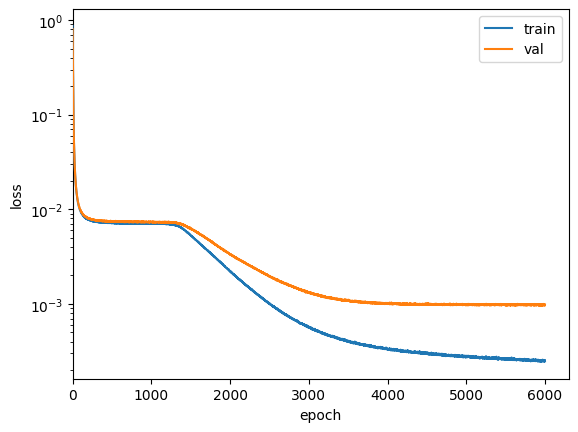

In [24]:
plt.semilogy(loss['train'], label='train', zorder=10)
plt.semilogy(loss['val'], label='val', zorder=10)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0,)
plt.legend()

In [25]:
state_dict = torch.load('./models/DKI_data_NLLoss_net.pt')
net = Net(100, 100, layers=[256])
net.load_state_dict(state_dict)

<All keys matched successfully>

In [26]:
import torch.nn.functional as F

In [27]:
X, Y = process_data('./data/DKI_data/Ptrain.csv')
K = calculate_keystone_array(X, Y, net)

100%|██████████| 500/500 [00:02<00:00, 234.79it/s]


/var/folders/ly/crjxkl596x59j9mv3_2mw1_00000gn/T/ipykernel_60243/2096576857.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = torch.exp(net(torch.tensor(x_batch[i]).unsqueeze(0)))


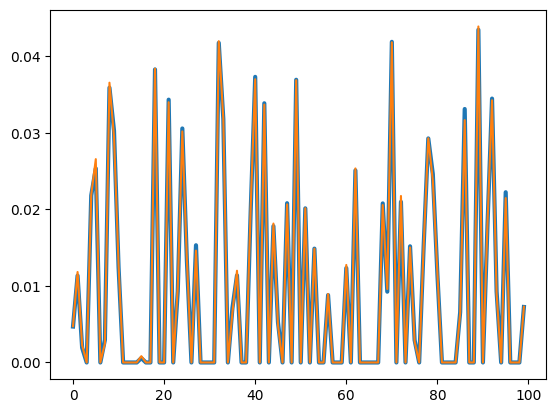

In [28]:
x_batch, y_batch = next(iter(val_loader))
i = 1
predicted = torch.exp(net(torch.tensor(x_batch[i]).unsqueeze(0)))
plt.plot(y_batch[i], label='true', lw=3)
plt.plot(predicted.detach().numpy().T, label='predicted')

<Axes: >

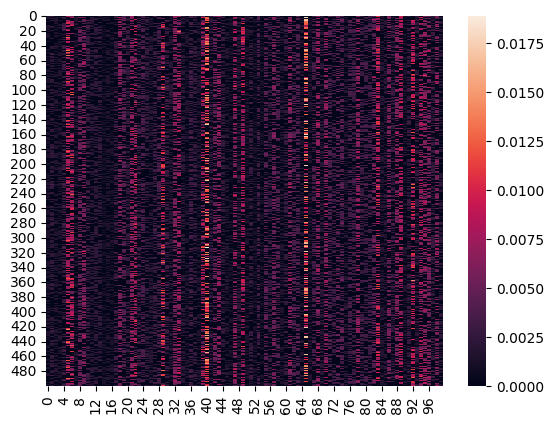

In [29]:
sns.heatmap(K)

In [30]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

In [31]:
# save as csv
np.savetxt('results/keystoness.csv', K, delimiter=',', header='i,j,K[i,j]')

In [32]:
import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['Species', 'Sample', 'Structural Keystoness'])
dataframe.tail(20)

,Species,Sample,Structural Keystoness
24980,100.0,459.0,0.002361
24981,100.0,461.0,0.002301
24982,100.0,462.0,0.001975
24983,100.0,463.0,0.002138
24984,100.0,467.0,0.002358
24985,100.0,468.0,0.002303
24986,100.0,470.0,0.002633
24987,100.0,471.0,0.002456
24988,100.0,473.0,0.002223
24989,100.0,474.0,0.002794


Text(0.5, 0, 'True keystones')

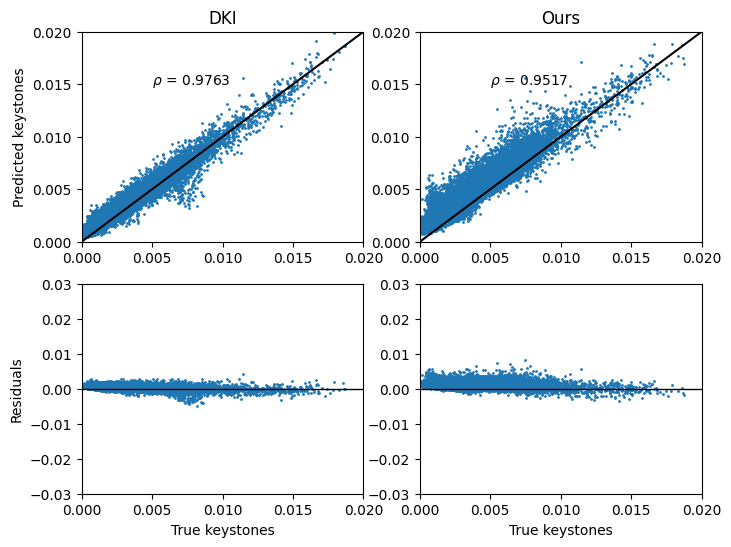

In [33]:

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(figsize=(8,6), ncols=2, nrows=2)
# fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
ax1.plot([0,0.03], [0,0.03], 'k-')
ax1.set_xlim(0,0.02)
ax1.set_ylim(0,0.02)
# ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.plot([0,0.03], [0,0.03], 'k-')
ax2.set_xlim(0,0.02)
ax2.set_ylim(0,0.02)
# ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

# correlation
from scipy.stats import pearsonr
ax1.text(0.005,0.015,f"${{\\rho}}$ = {pearsonr(true_keystones, pred_keystones)[0]:.4f}")
ax2.text(0.005,0.015,f"${{\\rho}}$ = {pearsonr(true_keystones, my_keystones)[0]:.4f}")

ax3.scatter(true_keystones, pred_keystones-true_keystones, s=1)
ax3.axhline(0, color='k', lw=1)
ax3.set_xlim(0,0.02)
ax3.set_ylim(-0.03,0.03)
ax3.set_xlabel('True keystones')
ax3.set_ylabel('Residuals')

ax4.scatter(true_keystones, my_keystones-true_keystones, s=1)
ax4.axhline(0, color='k', lw=1)
ax4.set_xlim(0,0.02)
ax4.set_ylim(-0.03,0.03)
ax4.set_xlabel('True keystones')


This model is highly sensitive to hyperparameters. You can definitely get better results than this.

# European Data

In [8]:
training_params = SimpleNamespace(
        file_path = './data/expt_data/Ptrain_NA.csv',
        batch_size = 32,
        val_size = 0.1,
        lr = 0.1,
        epochs = 500,
        verbosity = 10,
        layers = [128],
        output_name = 'EU_data',
    )

In [9]:
loss, model, train_loader, val_loader = train(training_params)

Epoch: 0 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 10 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 20 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 30 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 40 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 50 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 60 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 70 	Training Loss: 3.96e+00 	Validation Loss: 3.89e+00
Epoch: 80 	Training Loss: 3.96e+00 	Validation Loss: 3.88e+00
Epoch: 90 	Training Loss: 3.96e+00 	Validation Loss: 3.88e+00


: 

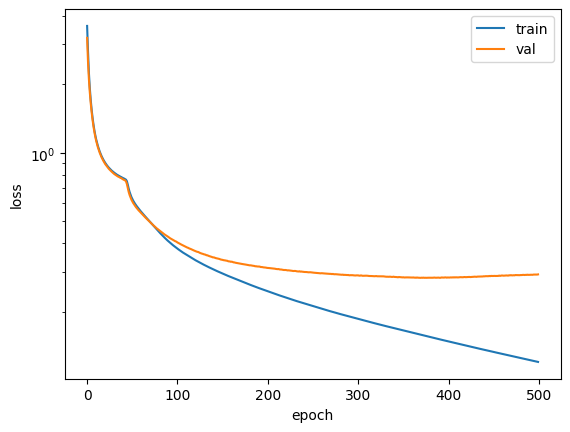

In [121]:
plt.semilogy(loss['train'], label='train')
plt.semilogy(loss['val'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [132]:
state_dict = torch.load('./models/EU_data_net.pt')
net = Net(1324, 1324, layers=[128])

net.load_state_dict(state_dict)

<All keys matched successfully>

In [138]:
X, Y = process_data('./data/expt_data/Ptrain_NA.csv')
K = calculate_keystone_array(X, Y, net)

100%|██████████| 2971/2971 [00:58<00:00, 51.03it/s] 


In [134]:
Y.shape

(2971, 1324)

<Axes: >

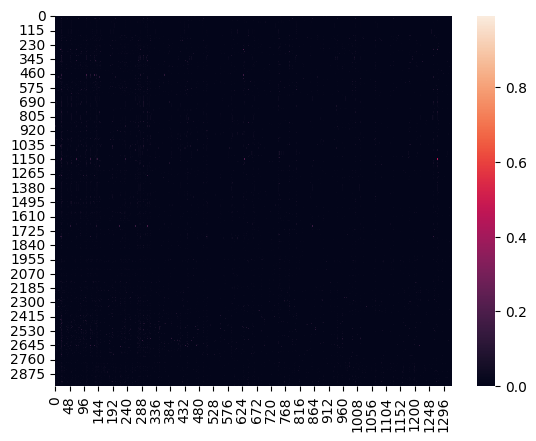

In [139]:
import seaborn as sns
sns.heatmap(K)

/var/folders/ly/crjxkl596x59j9mv3_2mw1_00000gn/T/ipykernel_60243/4176590506.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = torch.exp(net(torch.tensor(x_batch[i]).unsqueeze(0)))


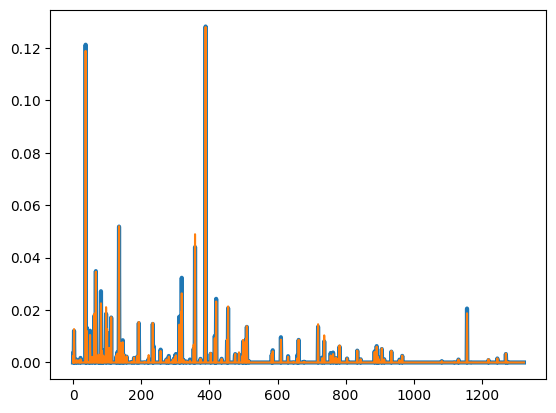

In [137]:
x_batch, y_batch = next(iter(val_loader))
i = 0
predicted = torch.exp(net(torch.tensor(x_batch[i]).unsqueeze(0)))
plt.plot(y_batch[i], label='true', lw=3)
plt.plot(predicted.detach().numpy().T, label='predicted')

In [12]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

# Implementing the Neural ODE from cNode

In [19]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

In [20]:
def get_batch(ztrn,ptrn,mb_size):
    s = torch.from_numpy(np.random.choice(np.arange(ptrn.size(dim=0), dtype=np.int64), mb_size, replace=False))
    batch_p = ztrn[s,:]
    batch_q = ptrn[s,:]
    batch_t = torch.tensor(np.linspace(0, 1, 100, endpoint=False), dtype=torch.float32)
    return batch_p.to(device), batch_q.to(device), batch_t.to(device)


def loss_bc(p_i, q_i):
    return torch.sum(torch.abs(p_i-q_i))/torch.sum(torch.abs(p_i+q_i))


def process_data(P):
    Z = P.copy()
    Z[Z>0] = 1
    P = P/P.sum(axis=0)[np.newaxis,:]
    Z = Z/Z.sum(axis=0)[np.newaxis,:]
    
    P = P.astype(np.float32)
    Z = Z.astype(np.float32)

    P = torch.from_numpy(P.T)
    Z = torch.from_numpy(Z.T)
    return P,Z


class ODEFunc(torch.nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.fcc1 = torch.nn.Linear(N, N)
        self.fcc2 = torch.nn.Linear(N, N)

    def forward(self, t, y):
        out = self.fcc1(y)
        out = nn.ReLU()(out)
        out = self.fcc2(out)
        f = torch.matmul(torch.matmul(torch.ones(y.size(dim=1),1),y),torch.transpose(out,0,1))
        return torch.mul(y,out-torch.transpose(f,0,1))

In [21]:
from tqdm import tqdm
import copy
import numpy as np

In [22]:
def train_reptile(max_epochs,mb,LR,ztrn,ptrn,zval,pval):
    loss_train = []
    loss_val = []
    
    func = ODEFunc().to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=LR)

    Loss_opt = 1
    loop_obj = tqdm(range(max_epochs))
    for e in loop_obj:
        
        func.train()
        optimizer.zero_grad()
        batch_p, batch_q, batch_t = get_batch(ztrn,ptrn,mb)
        
        for i in range(mb):
            p_pred = odeint(func,batch_p[i].unsqueeze(dim=0),batch_t)
            p_pred = torch.reshape(p_pred[-1,:,:],(1,N))
            if i==0:
                loss = loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
            else:
                loss = loss + loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
                
        loss_train.append(loss.item()/mb)

        func.zero_grad()
        loss.backward()
        optimizer.step()

        func.eval()
        for i in range(zval.size(dim=0)):
            with torch.no_grad():
                p_pred = odeint(func,zval[i].unsqueeze(dim=0),batch_t)
            p_pred = torch.reshape(p_pred[-1,:,:],(1,N))
            if i==0:
                l_val = loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
            else:
                l_val = l_val + loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
        loss_val.append(l_val.item()/zval.size(dim=0))
        if l_val.item()/zval.size(dim=0)<=Loss_opt:
            Loss_opt = loss_val[-1]
            best_model = copy.deepcopy(func)

        # update the neural network
        

        loop_obj.set_postfix_str(f"epoch: {e+1}, train loss: {loss_train[-1]:.4f} val loss: {loss_val[-1]:.4f}")
        

    return best_model, loss_train, loss_val

In [23]:
# hyperparameters
max_epochs = 100
device = 'cpu'
batch_time = 100
t = torch.arange(0.0, batch_time, 0.01)

# load the dataset
filepath_train = './data/DKI_data/Ptrain.csv'
# filepath_test = './data/DKI_data/Ptest.csv' # Replace "Ptest.csv" with "Ztest.csv" for real dataset.



In [24]:
P = np.loadtxt(filepath_train,delimiter=',')
number_of_cols = P.shape[1]
random_indices = np.random.choice(number_of_cols, size=int(0.2*number_of_cols), replace=False)
P_val = P[:,random_indices]
P_train =  P[:,np.setdiff1d(range(0,number_of_cols),random_indices)]
ptrn,ztrn = process_data(P_train)
pval,zval = process_data(P_val)
pall,zall = process_data(P)

M, N = ptrn.shape

In [25]:
LR = 0.01
mb = 20

best_model, loss_train, loss_val = train_reptile(max_epochs,mb,LR,ztrn.to(device),ptrn.to(device),zval.to(device),pval.to(device))

100%|██████████| 100/100 [01:56<00:00,  1.16s/it, epoch: 100, train loss: 0.0321 val loss: 0.0332]


Text(0, 0.5, 'Loss')

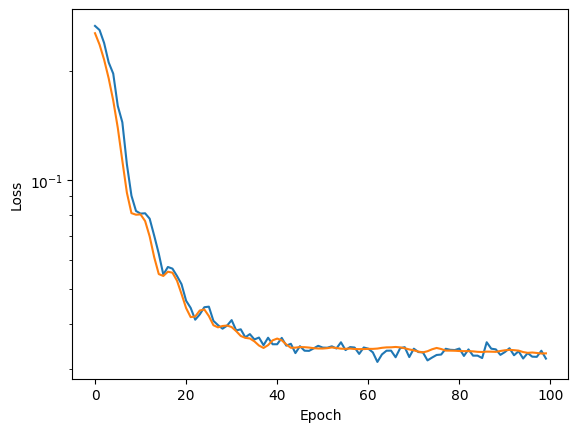

In [26]:
import matplotlib.pyplot as plt

plt.semilogy(loss_train)
plt.plot(loss_val)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [30]:
X, Y = process_data('./data/DKI_data/Ptrain.csv')
K = calculate_keystone_array(X, Y, best_model)

AttributeError: 'str' object has no attribute 'copy'

In [ ]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['Species', 'Sample', 'Structural Keystoness'])


fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
ax1.plot([0,0.03], [0,0.03], 'k-')
ax1.set_xlim(0,0.03)
ax1.set_ylim(0,0.03)
ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.plot([0,0.03], [0,0.03], 'k-')
ax2.set_xlim(0,0.03)
ax2.set_ylim(0,0.03)
ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

# correlation
from scipy.stats import pearsonr
ax1.text(0.005,0.02,f"${{\\rho}}$ = {pearsonr(true_keystones, pred_keystones)[0]:.4f}")
ax2.text(0.005,0.02,f"${{\\rho}}$ = {pearsonr(true_keystones, my_keystones)[0]:.4f}")


In [28]:
batch_t = torch.tensor(np.linspace(0, 1, 100, endpoint=False), dtype=torch.float32)
p_pred = odeint(best_model, torch.tensor(X[0]).unsqueeze(dim=0), batch_t)[-1,:,:]
# torch.reshape(p_pred[-1,:,:],(1,N))

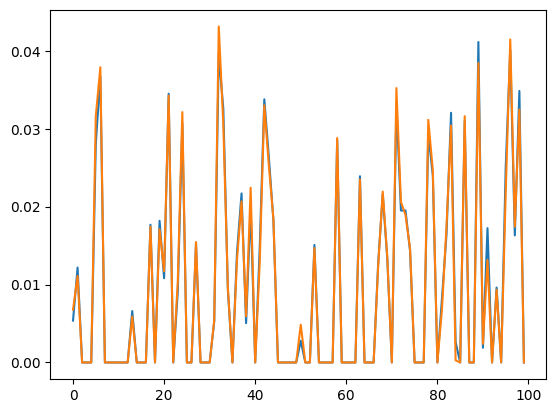

In [29]:
plt.plot(p_pred.detach().numpy().flatten())
plt.plot(Y[0])

In [31]:
import numpy as np
import torch
from scipy.spatial import distance
from tqdm import tqdm


def calculate_keystone(j, sample, original_abundance, model):
    # if the abundance is already zero, then the keystone index is zero
    p = original_abundance[j]

    if p == 0:
        return 0

    new_sample = sample.copy()

    sample = torch.tensor(sample, dtype=torch.float32)
    new_sample = torch.tensor(new_sample, dtype=torch.float32)
    with torch.no_grad():
        new_abundance = odeint(best_model, sample.reshape(1, -1), batch_t)[-1,:,:].detach().numpy().flatten()
        # new_abundance = model(torch.tensor(sample.reshape(1, -1), dtype=torch.float32)).numpy().flatten()

    new_sample[j] = 0
    new_abundance[j] = 0

    null_abundance = new_abundance / new_abundance.sum()

    with torch.no_grad():
        # predicted_abundance = model(torch.tensor(new_sample.reshape(1, -1), dtype=torch.float32)).numpy()
        predicted_abundance = odeint(best_model, new_sample.reshape(1, -1), batch_t)[-1,:,:].detach().numpy().flatten()
    
    k = distance.braycurtis(null_abundance, predicted_abundance.flatten()) * (1 - p)

    return k



def calculate_keystone_array(sample_array, sample_abundances, model):
    K = np.zeros((sample_array.shape[0], sample_array.shape[1]))

    for i, sample in enumerate(tqdm(sample_array)):
        original_abundance = sample_abundances[i]
        for j, _ in enumerate(sample):
            K[i, j] = calculate_keystone(j, sample, original_abundance, model)
            
    return K

In [32]:
K = calculate_keystone_array(X, Y, best_model)

100%|██████████| 500/500 [06:15<00:00,  1.33it/s]


<Axes: >

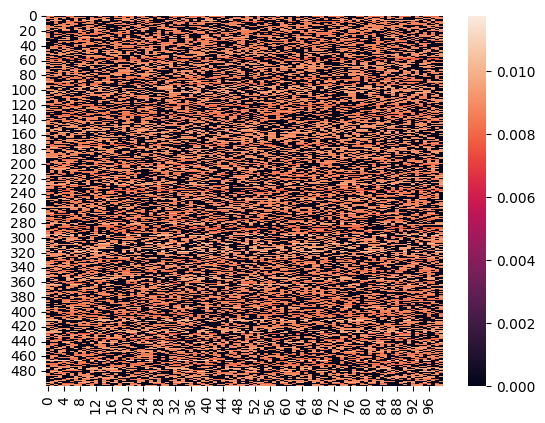

In [33]:
sns.heatmap(K)